# Aprendizaje Automatico - TP 1

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:g}'.format
plt.rcParams['figure.figsize'] = 14, 5

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from scripts.util import *
from scripts.builders import *

## Atributos

Definimos los siguientes atributos a ser extraidos de cada mail:
1. Atributos simples:
    - Longitud del asunto
    - Cantidad de espacios en el asunto dividido por la longitud del asunto
    - Cantidad de caracteres mayusculas en el asunto dividido por la longitud del asunto
    - Longitud del cuerpo
    - Cantidad de espacios en el cuerpo dividido por la longitud del cuerpo
    - Cantidad de caracteres mayusculas en el cuerpo dividido por la longitud del cuerpo
    - Cantidad de oraciones del cuerpo
    - Tiene el mail contenido HTML?
    - Tiene el mail imágenes?
2. Atributos de vectorizacion del asunto: cantidad de apariciones por token dividido por la cantidad de documentos en los que aparece(TF-IDF)
3. Atributos de vectorizacion del cuerpo: cantidad de apariciones por token dividido por la cantidad de documentos en los que aparece(TF-IDF)

## Reducción de dimensionalidad

Probaremos usando tres técnicas de selección de atributos:
    1. Elegir los 2 atributos que son mas probables(segun un test chi2) que sean dependientes de la etiqueta
    2. Entrenar un clasificador SVM lineal con penalización L1(fuerza esparcidad, gran cantidad de pesos en 0), 
        y elegir los 2 atributos que mas importancia tengan
    3. Analisis de Componentes Principales para reducción de dimensionalidad

## Modelos

Los algoritmos de aprendizaje para clasificación que utilizaremos son:

### TODO: Completar con los clasificadores
Explicar que corrimos todo con 10K samples a modo de prueba de sanidad y vimos que knn, svm y multinomial_nb no garpan, porque knn tiene un pico de memoria que no permite paralelizarlo, y por lo tanto la ejecucion del 10-Fold CV demora muchismo. SVM es paralelizable, pero también demora considerable cantidad de tiempo, y su performance es muy inferior a la de los métodos que dejamos. Multinomial no tarda, pero tambien tiene una performance muy inferior

## Ejecución y puntuación de cada pipeline

In [3]:
train_set, test_set = load_processed_data()
print ''
print_sets_summarys(train_set, test_set)

Loading Train Set
Done in 0.930000s

Loading Test Set
Done in 0.222000s

Train Set: 72000 samples - ham: 35997(0.50%) spam: 36003(0.50%)
Test Set:  18000 samples - ham: 9003(0.50%) spam: 8997(0.50%)


In [4]:
pipeline_types = [None, 'tfidf', 'k_best', 'l1', 'pca']
classifier_types = ['dt', 'random_forest', 'bernoulli_nb']
pipelines = build_all_pipelines(pipeline_types, pipeline_types, classifier_types)

In [5]:
scores, cv_times = evaluate_and_meassure(train_set, pipelines, 'full', cv=10, n_jobs=5)

Loading previous scores
Done in 0.003000s
Loading previous cv_times
Done in 0.000000s

Running 10-Fold CV for pipeline simple_features__dt(1/129)
Done in 116.166000s
CV scores mean: 0.925292 std: 0.001994

Running 10-Fold CV for pipeline simple_features__random_forest(2/129)
Done in 115.051000s
CV scores mean: 0.948792 std: 0.002090

Running 10-Fold CV for pipeline simple_features__bernoulli_nb(3/129)
Done in 115.901000s
CV scores mean: 0.830444 std: 0.004942

Running 10-Fold CV for pipeline simple_features__body_tfidf__dt(4/129)
Done in 252.677000s
CV scores mean: 0.978820 std: 0.001844

Running 10-Fold CV for pipeline simple_features__body_tfidf__random_forest(5/129)
Done in 174.236000s
CV scores mean: 0.985861 std: 0.000897

Running 10-Fold CV for pipeline simple_features__body_tfidf__bernoulli_nb(6/129)
Done in 151.599000s
CV scores mean: 0.899514 std: 0.003163

Running 10-Fold CV for pipeline simple_features__body_k_best__dt(7/129)
Done in 156.476000s
CV scores mean: 0.965889 std:

### TODO: Visualizaciones (usando DataFrame?) de los resultados, tanto puntajes de CV como runtimes

In [11]:
def build_summary_dataframe(pipelines, scores, cv_times):
    names = [name for name, _, _ in pipelines]

    df = pd.DataFrame(index=names, columns=['mean_cv_score', 'runtime'])

    df.mean_cv_score = [np.mean(scores[name]) for name in names]
    df.runtime = [cv_times[name] for name in names]

    df['simple_features'] = [configuration['simple_features'] for _, configuration, _ in pipelines]
    df['subject_pipeline'] = [configuration['subject_pipeline_type'] for _, configuration, _ in pipelines]
    df['body_pipeline'] = [configuration['body_pipeline_type'] for _, configuration, _ in pipelines]
    df['classifier'] = [configuration['classifier_type'] for _, configuration, _ in pipelines]

    return df

In [13]:
summary_df = build_summary_dataframe(pipelines, scores, cv_times)

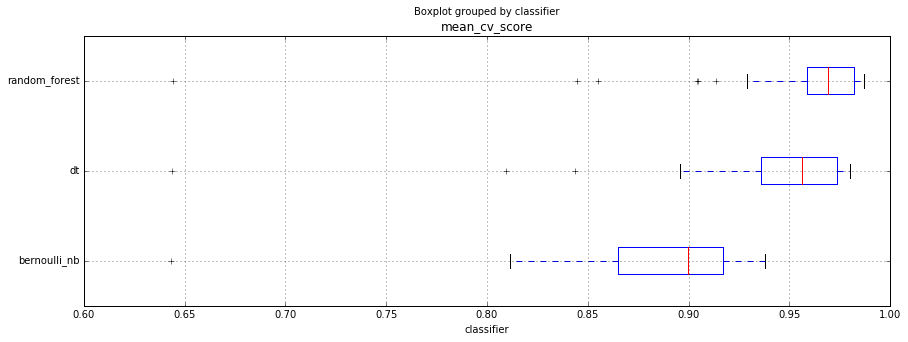

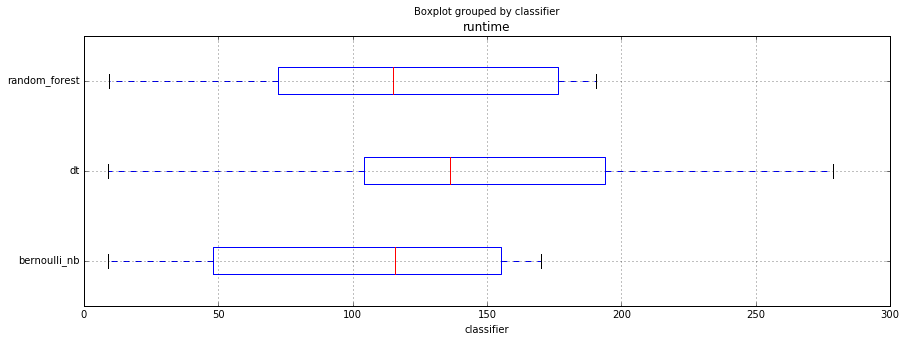

In [44]:
summary_df.boxplot(column=['mean_cv_score'], by='classifier', vert=False)
summary_df.boxplot(column=['runtime'], by='classifier', vert=False)

## Evaluacion del mejor pipeline en el set de test

Por último vamos a reportar el desempeño del mejor pipeline elegido con CV, en un set de datos limpio.
### TODO: elegir el mejor modelo de todos los que corrimos

In [6]:
mean_scores_list = [(name, np.mean(model_scores)) for name, model_scores in scores.iteritems()]
mean_scores_list[np.argmax(map(lambda x: x[1], mean_scores_list))]

('simple_features__subject_tfidf__body_l1__random_forest', 0.98698605694497932)

In [7]:
best_model_name, best_model = build_pipeline(True, 'tfidf', 'l1', 'random_forest')

In [8]:
def model_evaluation(pipeline, name, X_train, X_test):
    print 'Training pipeline %s in the train set' % name
    print_time(lambda: pipeline.fit(X_train, X_train.label))
    print ''
    
    print 'Classifying test set with pipeline %s' % name
    pred = print_time(lambda: pipeline.predict(X_test))
    print ''

    print 'Accuracy: %f' % accuracy_score(X_test.label, pred)
    print ''
    
    print 'Classification report:'
    print classification_report(X_test.label, pred, target_names=['ham', 'spam'])
    print 'Confusion matrix:'
    print pd.crosstab(X_test.label, pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [9]:
model_evaluation(best_model, best_model_name, train_set, test_set)

Training pipeline simple_features__subject_tfidf__body_l1__random_forest in the train set
Done in 69.160000s

Classifying test set with pipeline simple_features__subject_tfidf__body_l1__random_forest
Done in 14.479000s

Accuracy: 0.987222

Classification report:
             precision    recall  f1-score   support

        ham       0.98      0.99      0.99      9003
       spam       0.99      0.98      0.99      8997

avg / total       0.99      0.99      0.99     18000

Confusion matrix:
Predicted   ham  spam    All
True                        
ham        8915    88   9003
spam        142  8855   8997
All        9057  8943  18000


Guardamos este modelo para utilizarlo posteriormente en un programa separado

In [10]:
print 'Training pipeline %s in the full dataset' % best_model_name
_ = print_time(lambda: best_model.fit(train_set.append(test_set), train_set.append(test_set).label))

Training pipeline simple_features__subject_tfidf__body_l1__random_forest in the full dataset
Done in 89.005000s


In [11]:
save_model('best_model', 'results', best_model)

Saving model best_model to disk
Done in 3.037000s
Saved at results/best_model.pkl


## Exploración de atributos mas importantes

In [12]:
extractors = best_model.named_steps['feature_extractors']
simple_extractors = extractors.transformer_list[0][1]
subject_extractors = extractors.transformer_list[1][1]
subject_tfidf = subject_extractors.named_steps['tfidf']
body_extractors = extractors.transformer_list[2][1]
body_tfidf = body_extractors.named_steps['tfidf']
body_l1 = body_extractors.named_steps['l1']
rf = best_model.named_steps['random_forest']

feature_names = []
feature_names += [ 'simple_features_' + name  for name in simple_extractors.get_feature_names() ]
feature_names += [ 'subject_tfidf_' + name  for name in subject_tfidf.get_feature_names() ]
feature_names += [ 'body_l1_' + name  for name in body_l1.transform([body_tfidf.get_feature_names()])[0] ]
feature_names = np.asarray(feature_names)

In [13]:
extracted = extractors.transform(train_set)

In [14]:
top_features_indexs = np.argsort(rf.feature_importances_)[::-1][0:10]
top_features_importances = rf.feature_importances_[top_features_indexs]
top_feature_names = feature_names[top_features_indexs]
top_features = pd.DataFrame(extracted[:, top_features_indexs].todense(), columns=top_feature_names)
top_features['label'] = train_set.label

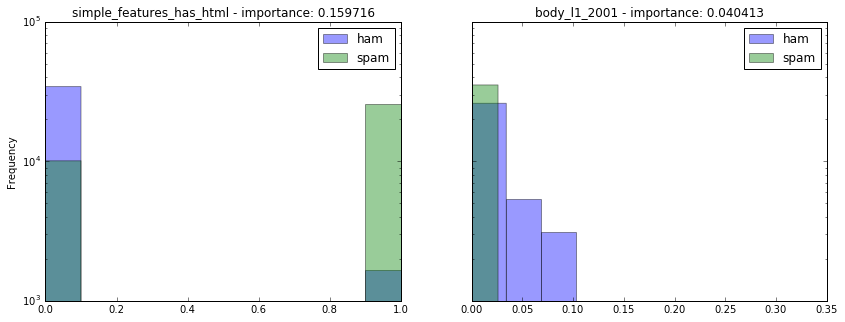

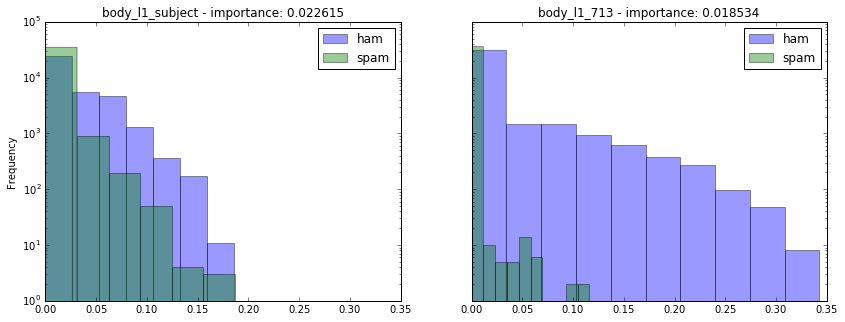

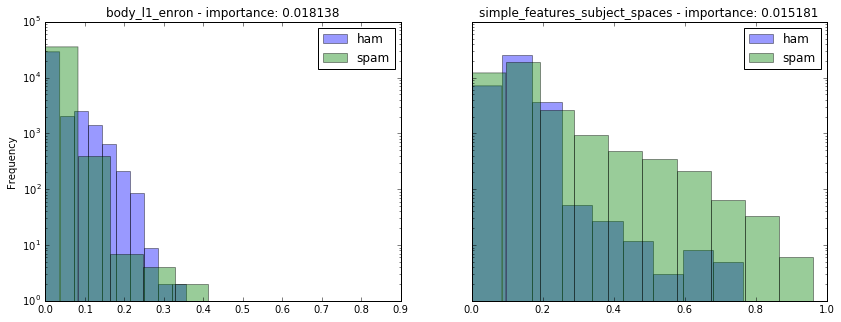

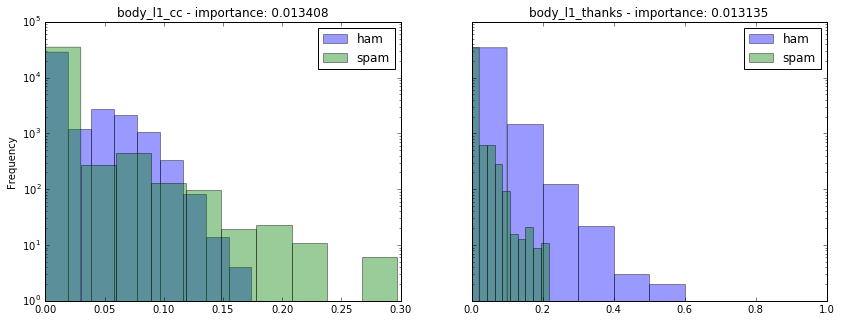

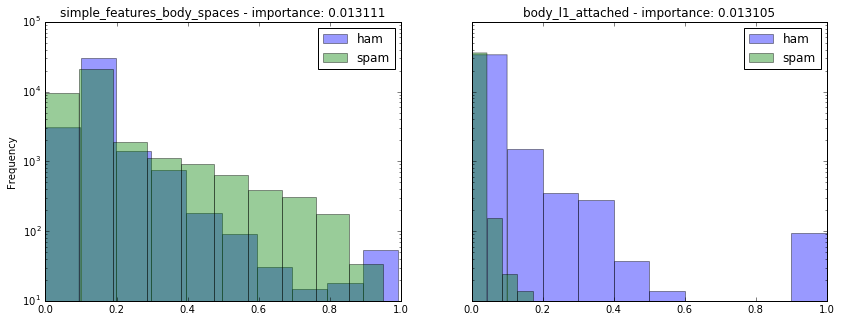

In [15]:
for i in range(10):
    if i % 2 == 0:
        fig, axs = plt.subplots(ncols=2, sharey=True)
        axs[0].set_yscale('log')
        axs[1].set_yscale('log')
    top_features.groupby('label')[top_feature_names[i]].plot(kind='hist',
                                            title=top_feature_names[i] + ' - importance: %f' % top_features_importances[i],
                                            ax=axs[i % 2],
                                            legend=True, alpha=0.4)
    

## Conclusiones

### TODO: Escribir conclusiones